In [14]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import sys
import itertools
import math
import pandas as pd
from PIL import Image, ImageDraw
rng = np.random.default_rng()

In [15]:
import sampling_and_kin_functions as skf

In [16]:
kibale = Image.open("Kibale_outline.png")
new_kibale = kibale.convert("L")
new_kibale.save("kibale.png")

In [19]:
# Sampled individuals
spatial_sample = pd.read_csv("spatial_sample.csv")
random_sample = pd.read_csv("random_sample.csv")

In [20]:
sample_parents = spatial_sample
# Find individuals in the sample that have a child in the sample
ind_in_p1 = np.isin(sample_parents.loc[:,'individual'].values, sample_parents.loc[:,'parent1'])
ind_in_p2 = np.isin(sample_parents.loc[:,'individual'].values, sample_parents.loc[:,'parent2'])

# Mothers and Fathers
mothers = sample_parents[ind_in_p1]
fathers = sample_parents[ind_in_p2]
mother_list = mothers.loc[:,'individual'].values
father_list = fathers.loc[:,'individual'].values

# Find the parents of children in the sample and how many children in the sample they have (the parents don't need to be in the sample)
# Mothers are parent1 and fathers are parent2
all_mothers, all_mother_counts = np.unique(sample_parents.loc[:,'parent1'].values, return_counts = True)
all_fathers, all_father_counts = np.unique(sample_parents.loc[:,'parent2'].values, return_counts = True)

# Find parents with multiple children in the sample (parents of siblings)
maternal_sib_parents = all_mothers[all_mother_counts > 1]
paternal_sib_parents = all_fathers[all_father_counts > 1]

# Record POPs and half-sibling pairs
maternal_pops = skf.find_POPs_or_sibs(mother_list, sample_parents, "PO")
paternal_pops = skf.find_POPs_or_sibs(father_list, sample_parents, "PO")
maternal_sibs = skf.find_POPs_or_sibs(maternal_sib_parents, sample_parents, "HS")
paternal_sibs = skf.find_POPs_or_sibs(paternal_sib_parents, sample_parents, "HS")

# Full sibling pairs appear in both maternal and paternal arrays
if np.any([x in paternal_sibs for x in maternal_sibs]):
    full_sibs = maternal_sibs[np.where([x in paternal_sibs for x in maternal_sibs])[0][0]]
else:
    full_sibs = []

# Plot maternal POPs, paternal POPs, and half-sibling pairs
w, h = 500, 500
max_width = 10
max_height = 10

pops_spaghetti = Image.new("1", (w, h))
img1 = ImageDraw.Draw(pops_spaghetti)
skf.draw_pairs(maternal_pops, img1, sample_parents, max_width, max_height, w, h)
skf.draw_pairs(paternal_pops, img1, sample_parents, max_width, max_height, w, h)

sibs_spaghetti = Image.new("1", (w, h))
img2 = ImageDraw.Draw(sibs_spaghetti)
skf.draw_pairs(maternal_sibs, img2, sample_parents, max_width, max_height, w, h)
skf.draw_pairs(paternal_sibs, img2, sample_parents, max_width, max_height, w, h)

# Number of parent offspring and HS pairs
npops = len(maternal_pops) + len(paternal_pops)
nsibs =  len(maternal_sibs) + len(paternal_sibs)

print("Number of parent offspring pairs: ", npops)
print("Number of half-sibling pairs: ", nsibs)
print("Number of full-sibling pairs: ", len(full_sibs))

Finding pairs
Finding pairs
Finding pairs
Finding pairs
Number of parent offspring pairs:  146
Number of half-sibling pairs:  596
Number of full-sibling pairs:  2


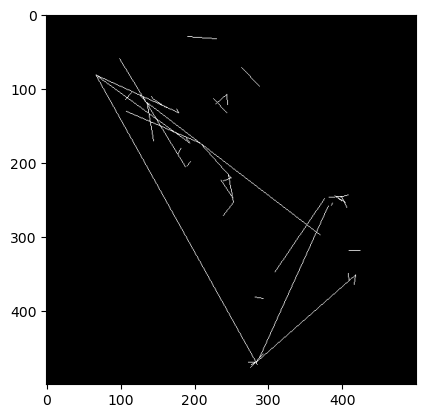

In [21]:
plt.imshow(pops_spaghetti)

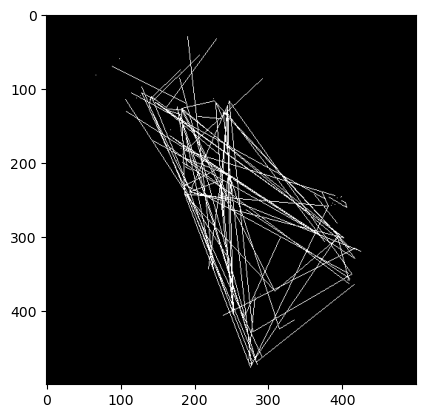

In [22]:
plt.imshow(sibs_spaghetti)